In [1]:
"""
Bit packing. Each agent is represented by 32 bits. This example uses 22 bits per agent.
"""

import sys
import numpy as np
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt
from enum import Enum
from numpy import array
from methods import *

In [2]:
class States(Enum):
    NULL = 0
    S = 1
    I = 2
    R = 3

In [3]:
# setup the way we will store our info
attr_sizes = OrderedDict()
attr_sizes['node']  = 5  # node id
attr_sizes['age']   = 15 # in days
attr_sizes['state'] = 2  # Null = 0,S = 1,I = 2, R = 3

# create the bit mapping (attribute: [ start, size])
bm = OrderedDict()
cnt = 0
for k,v in attr_sizes.items():
    bm[k] = [cnt, v]
    cnt += cnt + v
    
print('max size for our attributes:')
for k,v in attr_sizes.items():
    print(k, 2**v + 1)
print('\n bit mapping (starting bit position, number of bits):')
for k,v in bm.items():
    print(k, v)

max size for our attributes:
node 33
age 32769
state 5

 bit mapping (starting bit position, number of bits):
node [0, 5]
age [5, 15]
state [25, 2]


In [4]:
# Single node simulation

num_agents = 1_000_000
seed_infections = 10
R0 = 2.5
gamma = 1/10
num_timesteps = 365

# initialize the agent array
agents = np.zeros(num_agents, dtype=np.uint32)

# put everyone in node 1 for fun
agents = set_bits(agents, 1, *bm['node'])

# let's initialize everyone to susceptible
agents = set_bits(agents, States.S.value, *bm['state'])

# seed infections
seeds = np.random.randint(0, num_agents, seed_infections)
agents[seeds] = set_bits(agents[seeds],  States.I.value, *bm['state'])
print('Number of agents infected:', np.sum(check_bits(agents, *bm['state'], States.I.value)))

count = lambda state: np.sum(check_bits(agents, *bm['state'], state))

# main loop
record = np.zeros((num_timesteps, 4)) # t, S, I, R
for t in tqdm(range(num_timesteps)):

    # record
    record[t,:] = np.array([t, count(States.S.value), count(States.I.value), count(States.R.value)])
    
    # calculate the force of infection
    foi = np.sum(check_bits(agents, *bm['state'], States.I.value)) * R0 * gamma / num_agents

    # recover
    mask = np.logical_and(np.random.rand(num_agents) < gamma, check_bits(agents, *bm['state'], States.I.value))
    agents[mask] = set_bits(agents[mask], States.R.value, *bm['state'])
    
    # infect 
    mask = np.logical_and(np.random.rand(num_agents) < foi, check_bits(agents, *bm['state'], States.S.value))
    agents[mask] = set_bits(agents[mask], States.I.value, *bm['state'])
    

Number of agents infected: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [00:07<00:00, 52.08it/s]


Text(0, 0.5, 'Fraction')

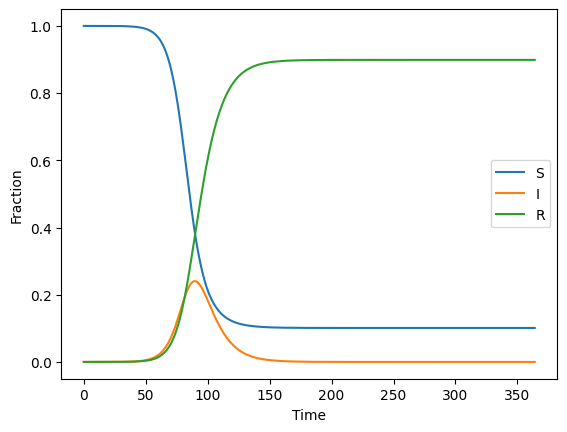

In [5]:
plt.plot(record[:,1:]/ num_agents)
plt.legend(['S','I','R'])
plt.xlabel('Time'); plt.ylabel('Fraction')